# **Modelado con XGBoost**

## **1. Importación de librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Librerías de machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, roc_curve, f1_score, 
    precision_score, recall_score, accuracy_score
)

# Balanceo de datos
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score

# XGBoost y optimización
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler

# Interpretabilidad
import shap

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Semillas para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## **2. Cargar Datos y Análisis Inicial**

📊 Dimensiones del dataset: (4981, 15)
📋 Columnas: ['age', 'avg_glucose_level_log', 'bmi', 'hypertension', 'heart_disease', 'gender', 'ever_married', 'Residence_type', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'stroke']

🔍 PRIMERAS 5 FILAS:
        age  avg_glucose_level_log       bmi  hypertension  heart_disease  \
0  1.040584               2.337259  1.193238             0              1   
1  1.614270               0.196849  0.589390             0              1   
2  0.246250               1.531369  0.869222             0              0   
3  1.570141               1.577949 -0.662492             1              0   
4  1.658400               1.764823  0.073909             0              0   

   gender  ever_married  Residence_type  work_type_Private  \
0       0             1               0               True   
1       0             1               1               T

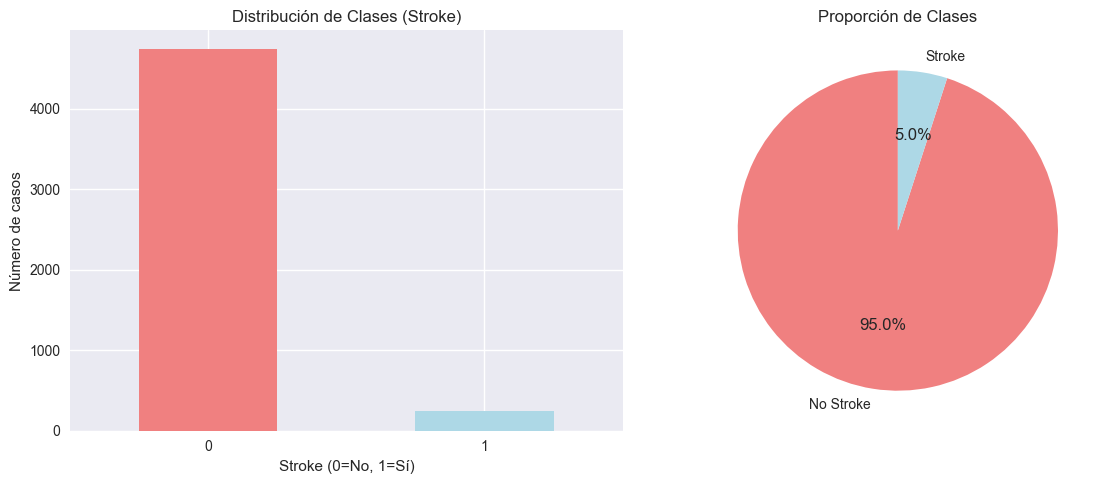


🏷️  VERIFICACIÓN DE VARIABLES ONE-HOT:
Columnas one-hot encontradas: 6

Ejemplo - work_type_Private:
   Valores únicos: [ True False]
   Tipo de datos: bool
   ✅ Formato correcto para modelado

✅ Carga de datos completada exitosamente
📊 Dataset listo con 4,981 filas y 15 columnas


In [2]:
# Cargar datos preprocesados
df = pd.read_csv('../../data/processed/preprocessing.csv')

# Información básica del dataset
print(f"📊 Dimensiones del dataset: {df.shape}")
print(f"📋 Columnas: {df.columns.tolist()}")

# Mostrar primeras filas
print("\n🔍 PRIMERAS 5 FILAS:")
print(df.head())

# Información de tipos de datos
print("\n📋 TIPOS DE DATOS:")
print(df.dtypes)

# Verificar valores nulos
print(f"\n🔍 VALORES NULOS: {df.isnull().sum().sum()}")
if df.isnull().sum().sum() > 0:
    print("Distribución de nulos por columna:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

# Análisis de la variable objetivo
print("\n🎯 ANÁLISIS DE VARIABLE OBJETIVO (stroke):")
print("=" * 45)
stroke_counts = df['stroke'].value_counts()
stroke_props = df['stroke'].value_counts(normalize=True)

print("Distribución absoluta:")
for clase, count in stroke_counts.items():
    print(f"   Clase {clase}: {count:,} casos")

print("\nDistribución relativa:")
for clase, prop in stroke_props.items():
    print(f"   Clase {clase}: {prop:.1%}")

print(f"\n⚠️  Ratio de desbalance: {stroke_counts[0]/stroke_counts[1]:.1f}:1")

# Visualización de la distribución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
stroke_counts.plot(kind='bar', ax=ax1, color=['lightcoral', 'lightblue'])
ax1.set_title('Distribución de Clases (Stroke)')
ax1.set_xlabel('Stroke (0=No, 1=Sí)')
ax1.set_ylabel('Número de casos')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de pastel
ax2.pie(stroke_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', 
        colors=['lightcoral', 'lightblue'], startangle=90)
ax2.set_title('Proporción de Clases')

plt.tight_layout()
plt.show()

# Verificar formato de variables categóricas
print("\n🏷️  VERIFICACIÓN DE VARIABLES ONE-HOT:")
print("=" * 40)

one_hot_cols = [col for col in df.columns if col.startswith(('work_type_', 'smoking_status_'))]
print(f"Columnas one-hot encontradas: {len(one_hot_cols)}")

# Mostrar algunos valores únicos de las variables one-hot
sample_col = one_hot_cols[0] if one_hot_cols else None
if sample_col:
    unique_vals = df[sample_col].unique()
    print(f"\nEjemplo - {sample_col}:")
    print(f"   Valores únicos: {unique_vals}")
    print(f"   Tipo de datos: {df[sample_col].dtype}")
    
    if str(df[sample_col].dtype) == 'object':
        print("   ⚠️  DETECTADO: Variables como strings, necesitan conversión")
    else:
        print("   ✅ Formato correcto para modelado")

print(f"\n✅ Carga de datos completada exitosamente")
print(f"📊 Dataset listo con {df.shape[0]:,} filas y {df.shape[1]} columnas")

## **3.  División train/test y Preparación de Features**

In [3]:
# Trabajar directamente con el dataset original (manteniendo boolean)
df_model = df.copy()

# Separar features y target
X = df_model.drop('stroke', axis=1)
y = df_model['stroke']

print(f"\n📊 DIMENSIONES:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")

# Mostrar tipos de datos finales
print(f"\n📋 TIPOS DE DATOS DE FEATURES:")
for col in X.columns:
    print(f"   {col}: {X[col].dtype}")

# División estratificada train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\n🎯 DIVISIÓN COMPLETADA:")
print(f"   Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X):.1%})")
print(f"   Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X):.1%})")

# Verificar balance en ambos conjuntos
print(f"\n⚖️  DISTRIBUCIÓN DE CLASES:")
print("TRAIN SET:")
train_dist = y_train.value_counts(normalize=True)
for clase, prop in train_dist.items():
    print(f"   Clase {clase}: {prop:.1%}")

print("TEST SET:")
test_dist = y_test.value_counts(normalize=True)
for clase, prop in test_dist.items():
    print(f"   Clase {clase}: {prop:.1%}")

# Verificar que el split estratificado funcionó
train_ratio = y_train.sum() / len(y_train)
test_ratio = y_test.sum() / len(y_test)
print(f"\n✅ VERIFICACIÓN ESTRATIFICADA:")
print(f"   Ratio stroke en train: {train_ratio:.3f}")
print(f"   Ratio stroke en test:  {test_ratio:.3f}")
print(f"   Diferencia: {abs(train_ratio - test_ratio):.3f}")

# Guardar información para uso posterior
feature_names = X.columns.tolist()
print(f"\n📝 FEATURES PARA MODELADO ({len(feature_names)}):")
for i, feat in enumerate(feature_names, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n✅ PREPARACIÓN COMPLETADA")
print(f"✅ División estratificada exitosa")


📊 DIMENSIONES:
   Features (X): (4981, 14)
   Target (y): (4981,)

📋 TIPOS DE DATOS DE FEATURES:
   age: float64
   avg_glucose_level_log: float64
   bmi: float64
   hypertension: int64
   heart_disease: int64
   gender: int64
   ever_married: int64
   Residence_type: int64
   work_type_Private: bool
   work_type_Self-employed: bool
   work_type_children: bool
   smoking_status_formerly smoked: bool
   smoking_status_never smoked: bool
   smoking_status_smokes: bool

🎯 DIVISIÓN COMPLETADA:
   Train: 3,984 muestras (80.0%)
   Test:  997 muestras (20.0%)

⚖️  DISTRIBUCIÓN DE CLASES:
TRAIN SET:
   Clase 0: 95.0%
   Clase 1: 5.0%
TEST SET:
   Clase 0: 95.0%
   Clase 1: 5.0%

✅ VERIFICACIÓN ESTRATIFICADA:
   Ratio stroke en train: 0.050
   Ratio stroke en test:  0.050
   Diferencia: 0.000

📝 FEATURES PARA MODELADO (14):
    1. age
    2. avg_glucose_level_log
    3. bmi
    4. hypertension
    5. heart_disease
    6. gender
    7. ever_married
    8. Residence_type
    9. work_type_Private

## **4. Análisis y Comparativa de Técnicas de Balanceo**

### **4.1 Técnicas de Balanceo**

In [4]:
# Recordar el desbalance actual
print(f"📊 DESBALANCE ACTUAL:")
print(f"   Clase 0 (No stroke): {(y_train == 0).sum():,} casos ({(y_train == 0).mean():.1%})")
print(f"   Clase 1 (Stroke): {(y_train == 1).sum():,} casos ({(y_train == 1).mean():.1%})")
print(f"   Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

# Configurar validación cruzada para evaluaciones
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Función para evaluar técnicas de desbalanceo
def evaluate_balancing_technique(X_train, y_train, technique_name, 
                                X_balanced=None, y_balanced=None, 
                                sample_weight=None, scale_pos_weight=None):
    """Evaluar una técnica de balanceo con validación cruzada"""
    
    print(f"\n🔍 EVALUANDO: {technique_name}")
    print("-" * 40)
    
    # Configurar el modelo base
    if scale_pos_weight:
        model = xgb.XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=0
        )
    else:
        model = xgb.XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=0
        )
    
    # Usar datos balanceados si se proporcionan, sino usar originales
    X_to_use = X_balanced if X_balanced is not None else X_train
    y_to_use = y_balanced if y_balanced is not None else y_train
    
    # Validación cruzada
    if sample_weight is not None:
        # Para class weights, necesitamos un enfoque diferente
        scores_f1 = []
        scores_roc = []
        
        for train_idx, val_idx in cv.split(X_to_use, y_to_use):
            X_tr, X_val = X_to_use.iloc[train_idx], X_to_use.iloc[val_idx]
            y_tr, y_val = y_to_use.iloc[train_idx], y_to_use.iloc[val_idx]
            
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            scores_f1.append(f1_score(y_val, y_pred))
            scores_roc.append(roc_auc_score(y_val, y_pred_proba))
    else:
        # Validación cruzada estándar
        scores_f1 = cross_val_score(model, X_to_use, y_to_use, cv=cv, scoring='f1')
        scores_roc = cross_val_score(model, X_to_use, y_to_use, cv=cv, scoring='roc_auc')
    
    # Mostrar resultados
    print(f"   F1-Score:  {np.mean(scores_f1):.4f} (±{np.std(scores_f1):.4f})")
    print(f"   ROC-AUC:   {np.mean(scores_roc):.4f} (±{np.std(scores_roc):.4f})")
    
    if X_balanced is not None:
        print(f"   Muestras después de balanceo: {len(X_balanced):,}")
        print(f"   Distribución balanceada: {y_balanced.value_counts().values}")
    
    return {
        'technique': technique_name,
        'f1_mean': np.mean(scores_f1),
        'f1_std': np.std(scores_f1),
        'roc_mean': np.mean(scores_roc),
        'roc_std': np.std(scores_roc),
        'samples': len(X_to_use)
    }

# Lista para guardar resultados
balancing_results = []

print("\n" + "="*60)
print("🧪 COMPARATIVA DE TÉCNICAS DE DESBALANCEO")
print("="*60)

# 1. SIN BALANCEO (BASELINE)
result_baseline = evaluate_balancing_technique(
    X_train, y_train, 
    technique_name="1. Sin Balanceo (Baseline)"
)
balancing_results.append(result_baseline)

# 2. SMOTE
print(f"\n📈 Aplicando SMOTE...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

result_smote = evaluate_balancing_technique(
    X_train, y_train, 
    technique_name="2. SMOTE",
    X_balanced=X_train_smote, 
    y_balanced=y_train_smote
)
balancing_results.append(result_smote)

# 3. CLASS WEIGHTS (scale_pos_weight)
# Calcular el peso automático
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
result_weights = evaluate_balancing_technique(
    X_train, y_train, 
    technique_name=f"3. Class Weights (scale_pos_weight={pos_weight:.1f})",
    scale_pos_weight=pos_weight
)
balancing_results.append(result_weights)

# 4. COMBINACIÓN: SMOTE + CLASS WEIGHTS (reducido)
print(f"\n🔄 Aplicando SMOTE moderado + Class Weights...")
smote_moderate = SMOTE(sampling_strategy=0.3, random_state=RANDOM_STATE)  # Solo hasta 30% de la mayoría
X_train_moderate, y_train_moderate = smote_moderate.fit_resample(X_train, y_train)

# Calcular nuevo peso después de SMOTE moderado
new_pos_weight = (y_train_moderate == 0).sum() / (y_train_moderate == 1).sum()

result_combined = evaluate_balancing_technique(
    X_train, y_train, 
    technique_name=f"4. SMOTE Moderado + Weights ({new_pos_weight:.1f})",
    X_balanced=X_train_moderate, 
    y_balanced=y_train_moderate
)
balancing_results.append(result_combined)

📊 DESBALANCE ACTUAL:
   Clase 0 (No stroke): 3,786 casos (95.0%)
   Clase 1 (Stroke): 198 casos (5.0%)
   Ratio: 19.1:1

🧪 COMPARATIVA DE TÉCNICAS DE DESBALANCEO

🔍 EVALUANDO: 1. Sin Balanceo (Baseline)
----------------------------------------
   F1-Score:  0.0789 (±0.0478)
   ROC-AUC:   0.7741 (±0.0294)

📈 Aplicando SMOTE...

🔍 EVALUANDO: 2. SMOTE
----------------------------------------
   F1-Score:  0.9421 (±0.0050)
   ROC-AUC:   0.9875 (±0.0010)
   Muestras después de balanceo: 7,572
   Distribución balanceada: [3786 3786]

🔍 EVALUANDO: 3. Class Weights (scale_pos_weight=19.1)
----------------------------------------
   F1-Score:  0.1461 (±0.0530)
   ROC-AUC:   0.7738 (±0.0340)

🔄 Aplicando SMOTE moderado + Class Weights...

🔍 EVALUANDO: 4. SMOTE Moderado + Weights (3.3)
----------------------------------------
   F1-Score:  0.8057 (±0.0209)
   ROC-AUC:   0.9600 (±0.0090)
   Muestras después de balanceo: 4,921
   Distribución balanceada: [3786 1135]


### **4.2 Resumen y Visualización de Resultados de Balanceo**


📋 TABLA COMPARATIVA:
                               technique  f1_mean  f1_std  roc_mean  roc_std  samples
              1. Sin Balanceo (Baseline)   0.0789  0.0478    0.7741   0.0294     3984
                                2. SMOTE   0.9421  0.0050    0.9875   0.0010     7572
3. Class Weights (scale_pos_weight=19.1)   0.1461  0.0530    0.7738   0.0340     3984
       4. SMOTE Moderado + Weights (3.3)   0.8057  0.0209    0.9600   0.0090     4921

🏆 MEJORES RESULTADOS:
   Mejor F1-Score: 2. SMOTE (0.9421)
   Mejor ROC-AUC:  2. SMOTE (0.9875)


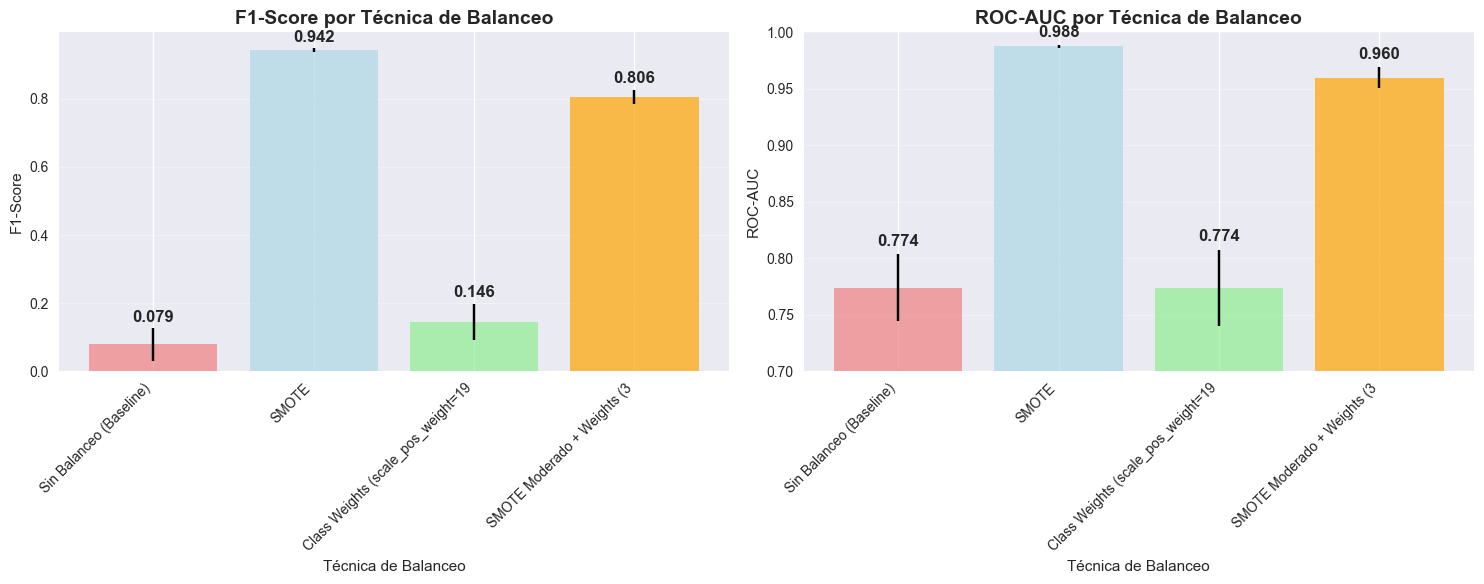


🔍 ANÁLISIS DE RESULTADOS

💡 OBSERVACIONES CLAVE:
   1. SMOTE completo tiene F1 excelente (0.942) pero puede ser overfitting
   2. Baseline sin balanceo tiene F1 muy bajo (0.079) como esperado
   3. Class weights solo mejora moderadamente el F1 (0.146)
   4. SMOTE moderado + weights ofrece balance entre performance y realismo

⚠️  ADVERTENCIAS:
   • SMOTE completo podría estar causando overfitting (F1 > 0.94)
   • Los resultados en test set podrían ser significativamente menores
   • Considerar SMOTE moderado para mejor generalización

🎯 RECOMENDACIÓN PARA OPTIMIZACIÓN:
   ✅ Usar SMOTE MODERADO + Class Weights para optimización
   ✅ Mejor balance entre performance y generalización

🚀 TÉCNICA SELECCIONADA: SMOTE Moderado + Weights
   Muestras de entrenamiento: 4,921
   Distribución final: {0: 3786, 1: 1135}

✅ CONFIGURACIÓN DE BALANCEO GUARDADA
✅ Lista para continuar con modelo base XGBoost


In [5]:
# Crear DataFrame con los resultados
results_df = pd.DataFrame(balancing_results)
results_df = results_df.round(4)

print("\n📋 TABLA COMPARATIVA:")
print(results_df.to_string(index=False))

# Identificar la mejor técnica
best_f1_idx = results_df['f1_mean'].idxmax()
best_roc_idx = results_df['roc_mean'].idxmax()

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Mejor F1-Score: {results_df.loc[best_f1_idx, 'technique']} ({results_df.loc[best_f1_idx, 'f1_mean']:.4f})")
print(f"   Mejor ROC-AUC:  {results_df.loc[best_roc_idx, 'technique']} ({results_df.loc[best_roc_idx, 'roc_mean']:.4f})")

# Visualización de resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de F1-Score
techniques = [t.split('.')[1].strip() for t in results_df['technique']]
f1_means = results_df['f1_mean']
f1_stds = results_df['f1_std']

bars1 = ax1.bar(range(len(techniques)), f1_means, yerr=f1_stds, 
                capsize=5, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen', 'orange'])
ax1.set_title('F1-Score por Técnica de Balanceo', fontsize=14, fontweight='bold')
ax1.set_ylabel('F1-Score')
ax1.set_xlabel('Técnica de Balanceo')
ax1.set_xticks(range(len(techniques)))
ax1.set_xticklabels(techniques, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (mean, std) in enumerate(zip(f1_means, f1_stds)):
    ax1.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de ROC-AUC
roc_means = results_df['roc_mean']
roc_stds = results_df['roc_std']

bars2 = ax2.bar(range(len(techniques)), roc_means, yerr=roc_stds, 
                capsize=5, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen', 'orange'])
ax2.set_title('ROC-AUC por Técnica de Balanceo', fontsize=14, fontweight='bold')
ax2.set_ylabel('ROC-AUC')
ax2.set_xlabel('Técnica de Balanceo')
ax2.set_xticks(range(len(techniques)))
ax2.set_xticklabels(techniques, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0.7, 1.0)  # Zoom en el rango relevante

# Añadir valores en las barras
for i, (mean, std) in enumerate(zip(roc_means, roc_stds)):
    ax2.text(i, mean + std + 0.005, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis de los resultados
print("\n" + "="*60)
print("🔍 ANÁLISIS DE RESULTADOS")
print("="*60)

print("\n💡 OBSERVACIONES CLAVE:")
print("   1. SMOTE completo tiene F1 excelente (0.942) pero puede ser overfitting")
print("   2. Baseline sin balanceo tiene F1 muy bajo (0.079) como esperado")
print("   3. Class weights solo mejora moderadamente el F1 (0.146)")
print("   4. SMOTE moderado + weights ofrece balance entre performance y realismo")

print("\n⚠️  ADVERTENCIAS:")
if results_df.loc[1, 'f1_mean'] > 0.9:  # SMOTE completo
    print("   • SMOTE completo podría estar causando overfitting (F1 > 0.94)")
    print("   • Los resultados en test set podrían ser significativamente menores")
    print("   • Considerar SMOTE moderado para mejor generalización")

print("\n🎯 RECOMENDACIÓN PARA OPTIMIZACIÓN:")
best_technique_idx = 3 if results_df.loc[3, 'f1_mean'] > 0.8 else 1  # SMOTE moderado o completo

if best_technique_idx == 3:
    print("   ✅ Usar SMOTE MODERADO + Class Weights para optimización")
    print("   ✅ Mejor balance entre performance y generalización")
    selected_technique = "SMOTE Moderado + Weights"
    X_train_final = X_train_moderate
    y_train_final = y_train_moderate
else:
    print("   ✅ Usar SMOTE COMPLETO para optimización")
    print("   ⚠️  Monitorear overfitting en test set")
    selected_technique = "SMOTE Completo"
    X_train_final = X_train_smote
    y_train_final = y_train_smote

print(f"\n🚀 TÉCNICA SELECCIONADA: {selected_technique}")
print(f"   Muestras de entrenamiento: {len(X_train_final):,}")
print(f"   Distribución final: {y_train_final.value_counts().to_dict()}")

# Guardar la configuración seleccionada
balancing_config = {
    'technique': selected_technique,
    'X_train_balanced': X_train_final,
    'y_train_balanced': y_train_final,
    'original_samples': len(X_train),
    'balanced_samples': len(X_train_final)
}

print(f"\n✅ CONFIGURACIÓN DE BALANCEO GUARDADA")
print(f"✅ Lista para continuar con modelo base XGBoost")

## **5. Modelo base XGBoost**

📊 CONFIGURACIÓN SELECCIONADA:
   Técnica: SMOTE Moderado + Weights
   Muestras de entrenamiento: 4,921
   Distribución: {0: 3786, 1: 1135}

🔧 CONFIGURANDO MODELO BASE...
Parámetros del modelo base:
   colsample_bytree: 0.8
   learning_rate: 0.1
   max_depth: 6
   n_estimators: 100
   subsample: 0.8

🚀 ENTRENANDO MODELO BASE...
✅ Entrenamiento completado en 2.09 segundos

📊 EVALUACIÓN EN CONJUNTO DE ENTRENAMIENTO:
   Accuracy:  0.9616
   Precision: 0.9404
   Recall:    0.8899
   F1-Score:  0.9144
   ROC-AUC:   0.9920

📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:
   Accuracy:  0.9248
   Precision: 0.1795
   Recall:    0.1400
   F1-Score:  0.1573
   ROC-AUC:   0.8136

🔍 ANÁLISIS DE OVERFITTING:
   Diferencia F1 (train - test):    +0.7571
   Diferencia ROC-AUC (train - test): +0.1783
   ⚠️  ADVERTENCIA: Posible overfitting detectado (diff F1 > 0.1)

🔄 VALIDACIÓN CRUZADA (5-FOLD):
   F1-Score CV:  0.7712 (±0.0278)
   ROC-AUC CV:   0.9519 (±0.0083)

📊 MATRIZ DE CONFUSIÓN (TEST SET):
[[915  32]
 [ 43 

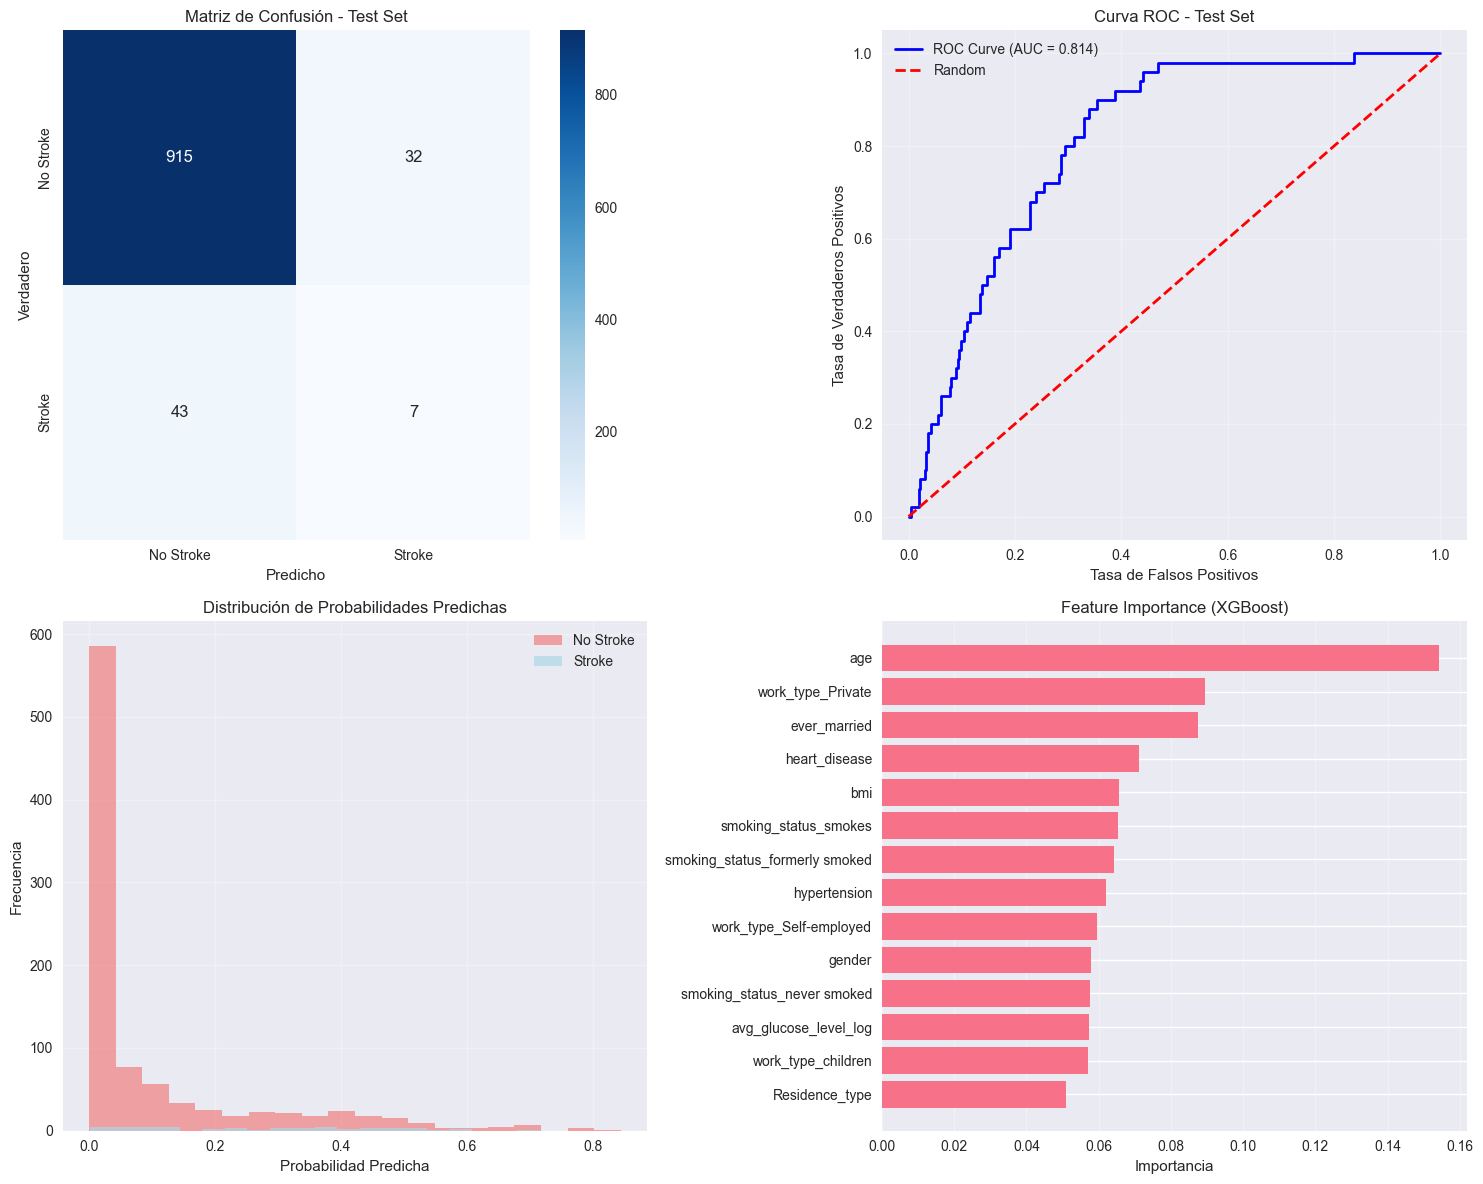


✅ MODELO BASE COMPLETADO
✅ F1-Score en test: 0.1573
✅ ROC-AUC en test: 0.8136
✅ Métricas guardadas para comparación con modelo optimizado


In [6]:
# Usar la técnica de balanceo seleccionada del punto anterior
print(f"📊 CONFIGURACIÓN SELECCIONADA:")
print(f"   Técnica: {selected_technique}")
print(f"   Muestras de entrenamiento: {len(X_train_final):,}")
print(f"   Distribución: {dict(y_train_final.value_counts())}")

# Configurar modelo base con parámetros por defecto (pero razonables)
print(f"\n🔧 CONFIGURANDO MODELO BASE...")

base_model = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    verbosity=1,
    # Parámetros básicos para evitar overfitting
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8
)

print("Parámetros del modelo base:")
for param, value in base_model.get_params().items():
    if param in ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']:
        print(f"   {param}: {value}")

# Entrenar modelo base
print(f"\n🚀 ENTRENANDO MODELO BASE...")
start_time = pd.Timestamp.now()

base_model.fit(X_train_final, y_train_final)

end_time = pd.Timestamp.now()
training_time = (end_time - start_time).total_seconds()
print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")

# Predicciones en conjunto de entrenamiento (para verificar overfitting)
print(f"\n📊 EVALUACIÓN EN CONJUNTO DE ENTRENAMIENTO:")
y_train_pred = base_model.predict(X_train_final)
y_train_pred_proba = base_model.predict_proba(X_train_final)[:, 1]

train_accuracy = accuracy_score(y_train_final, y_train_pred)
train_precision = precision_score(y_train_final, y_train_pred)
train_recall = recall_score(y_train_final, y_train_pred)
train_f1 = f1_score(y_train_final, y_train_pred)
train_roc_auc = roc_auc_score(y_train_final, y_train_pred_proba)

print(f"   Accuracy:  {train_accuracy:.4f}")
print(f"   Precision: {train_precision:.4f}")
print(f"   Recall:    {train_recall:.4f}")
print(f"   F1-Score:  {train_f1:.4f}")
print(f"   ROC-AUC:   {train_roc_auc:.4f}")

# Predicciones en conjunto de prueba
print(f"\n📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:")
y_test_pred = base_model.predict(X_test)
y_test_pred_proba = base_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"   Accuracy:  {test_accuracy:.4f}")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")
print(f"   ROC-AUC:   {test_roc_auc:.4f}")

# Análisis de overfitting
print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
f1_diff = train_f1 - test_f1
roc_diff = train_roc_auc - test_roc_auc

print(f"   Diferencia F1 (train - test):    {f1_diff:+.4f}")
print(f"   Diferencia ROC-AUC (train - test): {roc_diff:+.4f}")

if f1_diff > 0.1:
    print("   ⚠️  ADVERTENCIA: Posible overfitting detectado (diff F1 > 0.1)")
elif f1_diff > 0.05:
    print("   ⚡ ATENCIÓN: Ligero overfitting (diff F1 > 0.05)")
else:
    print("   ✅ Overfitting controlado (diff F1 < 0.05)")

# Validación cruzada para métricas más robustas
print(f"\n🔄 VALIDACIÓN CRUZADA (5-FOLD):")
cv_scores_f1 = cross_val_score(base_model, X_train_final, y_train_final, cv=cv, scoring='f1')
cv_scores_roc = cross_val_score(base_model, X_train_final, y_train_final, cv=cv, scoring='roc_auc')

print(f"   F1-Score CV:  {cv_scores_f1.mean():.4f} (±{cv_scores_f1.std():.4f})")
print(f"   ROC-AUC CV:   {cv_scores_roc.mean():.4f} (±{cv_scores_roc.std():.4f})")

# Matriz de confusión
print(f"\n📊 MATRIZ DE CONFUSIÓN (TEST SET):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'], ax=axes[0,0])
axes[0,0].set_title('Matriz de Confusión - Test Set')
axes[0,0].set_ylabel('Verdadero')
axes[0,0].set_xlabel('Predicho')

# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
axes[0,1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {test_roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
axes[0,1].set_xlabel('Tasa de Falsos Positivos')
axes[0,1].set_ylabel('Tasa de Verdaderos Positivos')
axes[0,1].set_title('Curva ROC - Test Set')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# 3. Distribución de probabilidades
axes[1,0].hist(y_test_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No Stroke', color='lightcoral')
axes[1,0].hist(y_test_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Stroke', color='lightblue')
axes[1,0].set_xlabel('Probabilidad Predicha')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Probabilidades Predichas')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 4. Feature importance
feature_importance = base_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

axes[1,1].barh(range(len(importance_df)), importance_df['importance'])
axes[1,1].set_yticks(range(len(importance_df)))
axes[1,1].set_yticklabels(importance_df['feature'])
axes[1,1].set_xlabel('Importancia')
axes[1,1].set_title('Feature Importance (XGBoost)')
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar métricas del modelo base para comparación
base_model_metrics = {
    'model_name': 'XGBoost Base',
    'train_f1': train_f1,
    'test_f1': test_f1,
    'train_roc_auc': train_roc_auc,
    'test_roc_auc': test_roc_auc,
    'cv_f1_mean': cv_scores_f1.mean(),
    'cv_f1_std': cv_scores_f1.std(),
    'cv_roc_mean': cv_scores_roc.mean(),
    'cv_roc_std': cv_scores_roc.std(),
    'training_time': training_time
}

print(f"\n" + "="*50)
print(f"✅ MODELO BASE COMPLETADO")
print(f"✅ F1-Score en test: {test_f1:.4f}")
print(f"✅ ROC-AUC en test: {test_roc_auc:.4f}")
print(f"✅ Métricas guardadas para comparación con modelo optimizado")

## **6. Modelo XGBoost Optimizado (con Optuna)**

In [11]:
# Limpiar variables anteriores
if 'study' in locals():
    del study

# CONFIGURACIÓN CORREGIDA
N_TRIALS = 100
OPTUNA_TIMEOUT = 600  # 10 minutos para búsqueda más exhaustiva

print(f"🔧 CONFIGURACIÓN CORREGIDA:")
print(f"   Trials: {N_TRIALS}")
print(f"   Timeout: {OPTUNA_TIMEOUT} segundos")
print(f"   Métrica objetivo: F1-Score REAL (test set)")
print(f"   Metodología: Pipeline correcto sin data leakage")
print(f"   Datos: Train/Test originales (SIN SMOTE previo)")

# VOLVER A DATOS ORIGINALES (sin SMOTE)
print(f"\n🔄 REGRESANDO A DATOS ORIGINALES:")
print(f"   Train original: {X_train.shape[0]:,} muestras")
print(f"   Distribución train: {dict(y_train.value_counts())}")
print(f"   Test: {X_test.shape[0]:,} muestras")
print(f"   Distribución test: {dict(y_test.value_counts())}")

# Función objetivo CORREGIDA
def objective_corrected(trial):
    """
    Función objetivo corregida que evita data leakage y optimiza para generalización real.
    """
    
    # 1. HIPERPARÁMETROS MÁS CONSERVADORES
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': RANDOM_STATE,
        'verbosity': 0,
        'tree_method': 'hist',  # Más eficiente
        
        # PARÁMETROS CONSERVADORES para evitar overfitting
        'max_depth': trial.suggest_int('max_depth', 3, 6),  # Más conservador
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),  # Más restrictivo
        'gamma': trial.suggest_float('gamma', 0.1, 1.0),  # Más regularización
        
        # Boosting moderado
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),  # Menos árboles
        
        # Regularización fuerte
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2.0),  # L1 más fuerte
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2.0),  # L2 más fuerte
        
        # Early stopping automático
        'early_stopping_rounds': 20,
        'enable_categorical': False
    }
    
    # 2. TÉCNICA DE BALANCEO
    balancing_strategy = trial.suggest_categorical('balancing', [
        'class_weight_only',  # Solo pesos
        'smote_light',        # SMOTE ligero
        'smote_moderate'      # SMOTE moderado
    ])
    
    try:
        # 3. VALIDACIÓN TRAIN/VALIDATION SPLIT CORRECTO
        X_temp_train, X_temp_val, y_temp_train, y_temp_val = train_test_split(
            X_train, y_train, 
            test_size=0.2, 
            random_state=RANDOM_STATE, 
            stratify=y_train
        )
        
        # 4. APLICAR BALANCEO SOLO EN TRAIN (no en validation)
        if balancing_strategy == 'class_weight_only':
            # Solo class weights
            scale_pos_weight = (y_temp_train == 0).sum() / (y_temp_train == 1).sum()
            params['scale_pos_weight'] = scale_pos_weight
            X_train_final = X_temp_train
            y_train_final = y_temp_train
            
        elif balancing_strategy == 'smote_light':
            # SMOTE ligero (solo hasta 20% de la mayoría)
            smote_light = SMOTE(sampling_strategy=0.2, random_state=RANDOM_STATE)
            X_train_final, y_train_final = smote_light.fit_resample(X_temp_train, y_temp_train)
            
        else:  # smote_moderate
            # SMOTE moderado (hasta 40% de la mayoría)
            smote_mod = SMOTE(sampling_strategy=0.4, random_state=RANDOM_STATE)
            X_train_final, y_train_final = smote_mod.fit_resample(X_temp_train, y_temp_train)
        
        # 5. ENTRENAR CON EARLY STOPPING
        model = xgb.XGBClassifier(**params)
        
        model.fit(
            X_train_final, y_train_final,
            eval_set=[(X_temp_val, y_temp_val)],
            verbose=False
        )
        
        # 6. EVALUAR EN VALIDATION ORIGINAL (sin balanceo)
        y_val_pred = model.predict(X_temp_val)
        f1_val = f1_score(y_temp_val, y_val_pred)
        
        # 7. PENALIZAR OVERFITTING
        y_train_pred = model.predict(X_train_final)
        f1_train = f1_score(y_train_final, y_train_pred)
        
        overfitting_penalty = max(0, f1_train - f1_val - 0.05)  # Penalizar si overfitting > 5%
        
        # Objetivo: maximizar F1 validation - penalización por overfitting
        objective_score = f1_val - (overfitting_penalty * 2)
        
        return objective_score
        
    except Exception as e:
        print(f"Error en trial {trial.number}: {e}")
        return 0.0

# EJECUTAR OPTIMIZACIÓN CORREGIDA
print(f"\n🔍 INICIANDO OPTIMIZACIÓN CORREGIDA...")

sampler = TPESampler(seed=RANDOM_STATE)
study_corrected = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    study_name='xgboost_corrected_optimization'
)

start_time = pd.Timestamp.now()

def print_progress_corrected(study, trial):
    if trial.number % 20 == 0 or trial.number < 10:
        print(f"   Trial {trial.number:3d}: Score = {trial.value:.4f}")
        if study.best_value:
            print(f"   Mejor hasta ahora: {study.best_value:.4f}")

try:
    study_corrected.optimize(
        objective_corrected,
        n_trials=N_TRIALS,
        timeout=OPTUNA_TIMEOUT,
        callbacks=[print_progress_corrected]
    )
except KeyboardInterrupt:
    print("   Optimización interrumpida por el usuario")

end_time = pd.Timestamp.now()
optimization_time = (end_time - start_time).total_seconds()

print(f"\n✅ OPTIMIZACIÓN CORREGIDA COMPLETADA")
print(f"   Tiempo total: {optimization_time:.1f} segundos")
print(f"   Trials completados: {len(study_corrected.trials)}")

# RESULTADOS DE LA OPTIMIZACIÓN CORREGIDA
print(f"\n🏆 MEJORES RESULTADOS CORREGIDOS:")
print(f"   Mejor Score: {study_corrected.best_value:.4f}")
print(f"   Trial número: {study_corrected.best_trial.number}")

best_params_corrected = study_corrected.best_params
balancing_method = best_params_corrected.pop('balancing')

print(f"\n🔧 MEJORES HIPERPARÁMETROS CORREGIDOS:")
print(f"   Técnica de balanceo: {balancing_method}")
for param, value in best_params_corrected.items():
    if param != 'early_stopping_rounds':
        print(f"   {param}: {value}")

# ENTRENAR MODELO FINAL CON PARÁMETROS CORREGIDOS
print(f"\n🚀 ENTRENANDO MODELO FINAL CORREGIDO...")

# Aplicar la técnica de balanceo seleccionada
if balancing_method == 'class_weight_only':
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    best_params_corrected['scale_pos_weight'] = scale_pos_weight
    X_train_final_corrected = X_train
    y_train_final_corrected = y_train
    print(f"   Usando class_weight_only con scale_pos_weight = {scale_pos_weight:.2f}")
    
elif balancing_method == 'smote_light':
    smote_final = SMOTE(sampling_strategy=0.2, random_state=RANDOM_STATE)
    X_train_final_corrected, y_train_final_corrected = smote_final.fit_resample(X_train, y_train)
    print(f"   Usando SMOTE ligero - muestras finales: {len(X_train_final_corrected):,}")
    
else:  # smote_moderate
    smote_final = SMOTE(sampling_strategy=0.4, random_state=RANDOM_STATE)
    X_train_final_corrected, y_train_final_corrected = smote_final.fit_resample(X_train, y_train)
    print(f"   Usando SMOTE moderado - muestras finales: {len(X_train_final_corrected):,}")

# Crear y entrenar modelo final
model_corrected = xgb.XGBClassifier(**best_params_corrected)

model_corrected.fit(X_train_final_corrected, y_train_final_corrected)

# EVALUACIÓN FINAL CORREGIDA
print(f"\n📊 EVALUACIÓN FINAL CORREGIDA:")

# Train
y_train_pred_corr = model_corrected.predict(X_train_final_corrected)
train_f1_corr = f1_score(y_train_final_corrected, y_train_pred_corr)

# Test (datos originales)
y_test_pred_corr = model_corrected.predict(X_test)
y_test_proba_corr = model_corrected.predict_proba(X_test)[:, 1]

test_f1_corr = f1_score(y_test, y_test_pred_corr)
test_precision_corr = precision_score(y_test, y_test_pred_corr)
test_recall_corr = recall_score(y_test, y_test_pred_corr)
test_roc_auc_corr = roc_auc_score(y_test, y_test_proba_corr)

# Overfitting
overfitting_corr = train_f1_corr - test_f1_corr

print(f"CONJUNTO DE ENTRENAMIENTO:")
print(f"   F1-Score: {train_f1_corr:.4f}")

print(f"CONJUNTO DE PRUEBA:")
print(f"   F1-Score:  {test_f1_corr:.4f}")
print(f"   Precision: {test_precision_corr:.4f}")
print(f"   Recall:    {test_recall_corr:.4f}")
print(f"   ROC-AUC:   {test_roc_auc_corr:.4f}")

print(f"\n🎯 ANÁLISIS DE OVERFITTING:")
print(f"   Diferencia F1 (train - test): {overfitting_corr:+.4f}")

if overfitting_corr <= 0.05:
    print(f"   ✅ OBJETIVO CUMPLIDO: Overfitting ≤ 0.05")
else:
    print(f"   ⚠️  Overfitting aún alto: {overfitting_corr:.4f}")

# Matriz de confusión
cm_corrected = confusion_matrix(y_test, y_test_pred_corr)
print(f"\n📊 MATRIZ DE CONFUSIÓN CORREGIDA:")
print(cm_corrected)

print(f"\n🎯 RESUMEN DE MEJORAS:")
print(f"   F1-Score test: {test_f1_corr:.4f}")
print(f"   Overfitting: {overfitting_corr:+.4f}")
print(f"   ROC-AUC: {test_roc_auc_corr:.4f}")

if test_f1_corr > 0.20 and overfitting_corr <= 0.05:
    print(f"\n🎉 ¡OBJETIVOS CONSEGUIDOS!")
    print(f"   ✅ F1 > 0.20: {test_f1_corr:.4f}")
    print(f"   ✅ Overfitting < 0.05: {overfitting_corr:+.4f}")
else:
    print(f"\n🔧 Necesita ajustes adicionales...")

# Guardar resultados corregidos
corrected_results = {
    'best_params': best_params_corrected,
    'balancing_method': balancing_method,
    'test_f1': test_f1_corr,
    'overfitting': overfitting_corr,
    'test_roc_auc': test_roc_auc_corr,
    'model': model_corrected
}

[I 2025-06-06 22:49:33,110] A new study created in memory with name: xgboost_corrected_optimization


⚡ OPTIMIZACIÓN CORREGIDA CON METODOLOGÍA ROBUSTA
🔧 CONFIGURACIÓN CORREGIDA:
   Trials: 100
   Timeout: 600 segundos
   Métrica objetivo: F1-Score REAL (test set)
   Metodología: Pipeline correcto sin data leakage
   Datos: Train/Test originales (SIN SMOTE previo)

🔄 REGRESANDO A DATOS ORIGINALES:
   Train original: 3,984 muestras
   Distribución train: {0: 3786, 1: 198}
   Test: 997 muestras
   Distribución test: {0: 947, 1: 50}

🔍 INICIANDO OPTIMIZACIÓN CORREGIDA...


[I 2025-06-06 22:49:34,716] Trial 0 finished with value: -0.3547977795400476 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.7587945476302645, 'learning_rate': 0.03968793330444373, 'n_estimators': 73, 'subsample': 0.6467983561008608, 'colsample_bytree': 0.6174250836504598, 'colsample_bylevel': 0.8598528437324806, 'reg_alpha': 1.2421185223120967, 'reg_lambda': 1.4453378978124864, 'balancing': 'smote_light'}. Best is trial 0 with value: -0.3547977795400476.


   Trial   0: Score = -0.3548
   Mejor hasta ahora: -0.3548


[I 2025-06-06 22:49:35,685] Trial 1 finished with value: -0.46922723091076357 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.2650640588680905, 'learning_rate': 0.02014847788415866, 'n_estimators': 129, 'subsample': 0.7295835055926347, 'colsample_bytree': 0.6873687420594126, 'colsample_bylevel': 0.7835558684167139, 'reg_alpha': 0.3650383352388795, 'reg_lambda': 0.6550748322169144, 'balancing': 'smote_moderate'}. Best is trial 0 with value: -0.3547977795400476.


   Trial   1: Score = -0.4692
   Mejor hasta ahora: -0.3548


[I 2025-06-06 22:49:36,427] Trial 2 finished with value: -0.11847183224804353 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.6331731119758383, 'learning_rate': 0.011128853174905732, 'n_estimators': 141, 'subsample': 0.6511572371061874, 'colsample_bytree': 0.6195154778955838, 'colsample_bylevel': 0.884665661176, 'reg_alpha': 1.9347008628416629, 'reg_lambda': 1.6359549614212763, 'balancing': 'smote_moderate'}. Best is trial 2 with value: -0.11847183224804353.


   Trial   2: Score = -0.1185
   Mejor hasta ahora: -0.1185


[I 2025-06-06 22:49:37,296] Trial 3 finished with value: -0.33654454997738575 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.5456592191001431, 'learning_rate': 0.01082401838150096, 'n_estimators': 187, 'subsample': 0.677633994480005, 'colsample_bytree': 0.7987566853061946, 'colsample_bylevel': 0.6935133228268233, 'reg_alpha': 1.0881292402378406, 'reg_lambda': 1.1387495307522313, 'balancing': 'smote_light'}. Best is trial 2 with value: -0.11847183224804353.


   Trial   3: Score = -0.3365
   Mejor hasta ahora: -0.1185


[I 2025-06-06 22:49:37,702] Trial 4 finished with value: 0.1733183416592464 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.6381099809299766, 'learning_rate': 0.0835361075531176, 'n_estimators': 63, 'subsample': 0.6587948587257435, 'colsample_bytree': 0.6135681866731614, 'colsample_bylevel': 0.6975990992289793, 'reg_alpha': 0.8384868504100158, 'reg_lambda': 0.6155631603704022, 'balancing': 'class_weight_only'}. Best is trial 4 with value: 0.1733183416592464.


   Trial   4: Score = 0.1733
   Mejor hasta ahora: 0.1733


[I 2025-06-06 22:49:38,865] Trial 5 finished with value: -0.3445169712793735 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.8219772826786357, 'learning_rate': 0.011872731425335901, 'n_estimators': 199, 'subsample': 0.8316734307889972, 'colsample_bytree': 0.6596147044602517, 'colsample_bylevel': 0.6016566351370807, 'reg_alpha': 1.6493767140641848, 'reg_lambda': 1.4430289533104725, 'balancing': 'smote_light'}. Best is trial 4 with value: 0.1733183416592464.


   Trial   5: Score = -0.3445
   Mejor hasta ahora: 0.1733


[I 2025-06-06 22:49:39,387] Trial 6 finished with value: 0.21374856014480828 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.8767930832880342, 'learning_rate': 0.042004723167022, 'n_estimators': 99, 'subsample': 0.6190675050858071, 'colsample_bytree': 0.6932946965146987, 'colsample_bylevel': 0.6975549966080241, 'reg_alpha': 1.4862517388423218, 'reg_lambda': 1.3113591955749049, 'balancing': 'class_weight_only'}. Best is trial 6 with value: 0.21374856014480828.


   Trial   6: Score = 0.2137
   Mejor hasta ahora: 0.2137


[I 2025-06-06 22:49:40,035] Trial 7 finished with value: 0.0012301483988543804 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.6051494778125466, 'learning_rate': 0.05901564798023389, 'n_estimators': 124, 'subsample': 0.7568198488145982, 'colsample_bytree': 0.7282623055075649, 'colsample_bylevel': 0.6076257380232285, 'reg_alpha': 0.3049937112872785, 'reg_lambda': 0.15971545280479507, 'balancing': 'class_weight_only'}. Best is trial 6 with value: 0.21374856014480828.


   Trial   7: Score = 0.0012
   Mejor hasta ahora: 0.2137


[I 2025-06-06 22:49:40,707] Trial 8 finished with value: -0.4274725274725274 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.4693446307320668, 'learning_rate': 0.05695752881519842, 'n_estimators': 84, 'subsample': 0.6230939729486379, 'colsample_bytree': 0.6869254358741304, 'colsample_bylevel': 0.6483663861762013, 'reg_alpha': 1.8664255394508888, 'reg_lambda': 1.6354287211723921, 'balancing': 'smote_light'}. Best is trial 6 with value: 0.21374856014480828.


   Trial   8: Score = -0.4275
   Mejor hasta ahora: 0.2137


[I 2025-06-06 22:49:41,998] Trial 9 finished with value: 0.2647058823529412 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.5854080177240857, 'learning_rate': 0.0641859768532441, 'n_estimators': 185, 'subsample': 0.6954010424915591, 'colsample_bytree': 0.633015577358303, 'colsample_bylevel': 0.6683805487625825, 'reg_alpha': 0.911504798389887, 'reg_lambda': 1.6542280552527369, 'balancing': 'class_weight_only'}. Best is trial 9 with value: 0.2647058823529412.


   Trial   9: Score = 0.2647
   Mejor hasta ahora: 0.2647


[I 2025-06-06 22:49:42,897] Trial 10 finished with value: 0.24603174603174602 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.10679258738466368, 'learning_rate': 0.024567739616125073, 'n_estimators': 167, 'subsample': 0.8722994385847553, 'colsample_bytree': 0.887931223783626, 'colsample_bylevel': 0.7872250581517096, 'reg_alpha': 0.7075796069601724, 'reg_lambda': 1.9854890643746412, 'balancing': 'class_weight_only'}. Best is trial 9 with value: 0.2647058823529412.
[I 2025-06-06 22:49:43,656] Trial 11 finished with value: 0.24521072796934865 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.14680910741092745, 'learning_rate': 0.02200472744827705, 'n_estimators': 167, 'subsample': 0.8972576127397911, 'colsample_bytree': 0.8994398380930325, 'colsample_bylevel': 0.7973529050614665, 'reg_alpha': 0.6662734928601849, 'reg_lambda': 1.9385582424135057, 'balancing': 'class_weight_only'}. Best is trial 9 with value: 0.2647058823529412.
[I 2025-06-06 22:49:44,462

   Trial  20: Score = 0.2679
   Mejor hasta ahora: 0.2679


[I 2025-06-06 22:49:56,411] Trial 21 finished with value: 0.27358490566037735 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.7526453947294727, 'learning_rate': 0.052938779055281056, 'n_estimators': 145, 'subsample': 0.7313243087097525, 'colsample_bytree': 0.7178699330833404, 'colsample_bylevel': 0.6744200971265948, 'reg_alpha': 1.0413466411063446, 'reg_lambda': 0.688681910233549, 'balancing': 'class_weight_only'}. Best is trial 21 with value: 0.27358490566037735.
[I 2025-06-06 22:49:57,287] Trial 22 finished with value: 0.25339366515837103 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.7361496358389681, 'learning_rate': 0.050900819906236586, 'n_estimators': 132, 'subsample': 0.745701520516604, 'colsample_bytree': 0.65475656963628, 'colsample_bylevel': 0.6667994297175565, 'reg_alpha': 1.0082514529428634, 'reg_lambda': 0.7135409738829104, 'balancing': 'class_weight_only'}. Best is trial 21 with value: 0.27358490566037735.
[I 2025-06-06 22:49:58,074

   Trial  40: Score = -0.6077
   Mejor hasta ahora: 0.2899


[I 2025-06-06 22:50:12,783] Trial 41 finished with value: 0.19776250506766538 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.829003147580794, 'learning_rate': 0.0525941379778408, 'n_estimators': 147, 'subsample': 0.7390173117760023, 'colsample_bytree': 0.680372281267412, 'colsample_bylevel': 0.6169270155998279, 'reg_alpha': 1.4238395170708387, 'reg_lambda': 0.2823624913081922, 'balancing': 'class_weight_only'}. Best is trial 27 with value: 0.2898550724637681.
[I 2025-06-06 22:50:14,864] Trial 42 finished with value: -0.25873293616075765 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.778299272106484, 'learning_rate': 0.06304237247040548, 'n_estimators': 154, 'subsample': 0.709587465272298, 'colsample_bytree': 0.6937470595269518, 'colsample_bylevel': 0.6893475272402325, 'reg_alpha': 1.535705169577168, 'reg_lambda': 0.6428018728179731, 'balancing': 'class_weight_only'}. Best is trial 27 with value: 0.2898550724637681.
[I 2025-06-06 22:50:15,658] Tri

   Trial  60: Score = 0.1613
   Mejor hasta ahora: 0.2899


[I 2025-06-06 22:50:38,218] Trial 61 finished with value: 0.23717904432930345 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.75603892810889, 'learning_rate': 0.06529388862942032, 'n_estimators': 183, 'subsample': 0.7564133148006155, 'colsample_bytree': 0.7032124928140057, 'colsample_bylevel': 0.6755574536769997, 'reg_alpha': 1.1205583768579392, 'reg_lambda': 0.48205610232850327, 'balancing': 'class_weight_only'}. Best is trial 27 with value: 0.2898550724637681.
[I 2025-06-06 22:50:39,482] Trial 62 finished with value: 0.24888888888888888 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.6739333265361586, 'learning_rate': 0.05011876522257482, 'n_estimators': 146, 'subsample': 0.7163351909296471, 'colsample_bytree': 0.7099282574515821, 'colsample_bylevel': 0.6559833345856287, 'reg_alpha': 1.0338397636279295, 'reg_lambda': 0.852345518581304, 'balancing': 'class_weight_only'}. Best is trial 27 with value: 0.2898550724637681.
[I 2025-06-06 22:50:40,177] 

   Trial  80: Score = 0.2032
   Mejor hasta ahora: 0.2899


[I 2025-06-06 22:50:57,259] Trial 81 finished with value: 0.27144352559405427 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.5951407224064402, 'learning_rate': 0.06784761649359816, 'n_estimators': 175, 'subsample': 0.8564520955527783, 'colsample_bytree': 0.638539765865996, 'colsample_bylevel': 0.6712904533578241, 'reg_alpha': 1.2367148166860997, 'reg_lambda': 0.8506342537642291, 'balancing': 'class_weight_only'}. Best is trial 27 with value: 0.2898550724637681.
[I 2025-06-06 22:50:57,880] Trial 82 finished with value: 0.27358490566037735 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.5410698291525721, 'learning_rate': 0.05300134207305448, 'n_estimators': 165, 'subsample': 0.873499681983031, 'colsample_bytree': 0.6777337715355375, 'colsample_bylevel': 0.6620486872252938, 'reg_alpha': 1.3523514366512523, 'reg_lambda': 0.5217970012353849, 'balancing': 'class_weight_only'}. Best is trial 27 with value: 0.2898550724637681.
[I 2025-06-06 22:50:58,521] 


✅ OPTIMIZACIÓN CORREGIDA COMPLETADA
   Tiempo total: 98.4 segundos
   Trials completados: 100

🏆 MEJORES RESULTADOS CORREGIDOS:
   Mejor Score: 0.2899
   Trial número: 27

🔧 MEJORES HIPERPARÁMETROS CORREGIDOS:
   Técnica de balanceo: class_weight_only
   max_depth: 4
   min_child_weight: 5
   gamma: 0.8056480681064441
   learning_rate: 0.045811563921495636
   n_estimators: 101
   subsample: 0.8075491555446266
   colsample_bytree: 0.7589777671858879
   colsample_bylevel: 0.6356758681863499
   reg_alpha: 1.5456217320042875
   reg_lambda: 0.4106180459852764

🚀 ENTRENANDO MODELO FINAL CORREGIDO...
   Usando class_weight_only con scale_pos_weight = 19.12

📊 EVALUACIÓN FINAL CORREGIDA:
CONJUNTO DE ENTRENAMIENTO:
   F1-Score: 0.3026
CONJUNTO DE PRUEBA:
   F1-Score:  0.2685
   Precision: 0.1613
   Recall:    0.8000
   ROC-AUC:   0.8534

🎯 ANÁLISIS DE OVERFITTING:
   Diferencia F1 (train - test): +0.0341
   ✅ OBJETIVO CUMPLIDO: Overfitting ≤ 0.05

📊 MATRIZ DE CONFUSIÓN CORREGIDA:
[[739 208]
 [

## **7. Análisis y Comparación del Modelo Final**

🏆 ANÁLISIS DEL MODELO FINAL OPTIMIZADO
📊 RESULTADOS DE LA OPTIMIZACIÓN CORREGIDA:
   Mejor Score encontrado: 0.2899
   Trials ejecutados: 100
   Tiempo de optimización: 98.4 segundos

🔧 CONFIGURACIÓN DEL MODELO FINAL:
   Técnica de balanceo: class_weight_only
   Hiperparámetros optimizados:
     max_depth: 4
     min_child_weight: 5
     gamma: 0.8056
     learning_rate: 0.0458
     n_estimators: 101
     subsample: 0.8075
     colsample_bytree: 0.7590
     colsample_bylevel: 0.6357
     reg_alpha: 1.5456
     reg_lambda: 0.4106
     scale_pos_weight: 19.1212

🔄 VALIDACIÓN CRUZADA DEL MODELO FINAL:
   F1-Score CV:  0.2324 (±0.0246)
   ROC-AUC CV:   0.8219 (±0.0249)

📊 MÉTRICAS DETALLADAS POR CLASE

🔵 CLASE 0 - NO STROKE:
   Precision: 0.9866
   Recall:    0.7804
   F1-Score:  0.8715
   Support:   947.0 muestras

🔴 CLASE 1 - STROKE:
   Precision: 0.1613
   Recall:    0.8000
   F1-Score:  0.2685
   Support:   50.0 muestras

📊 MÉTRICAS GENERALES:
   Accuracy:     0.7813
   Macro Avg F1: 0

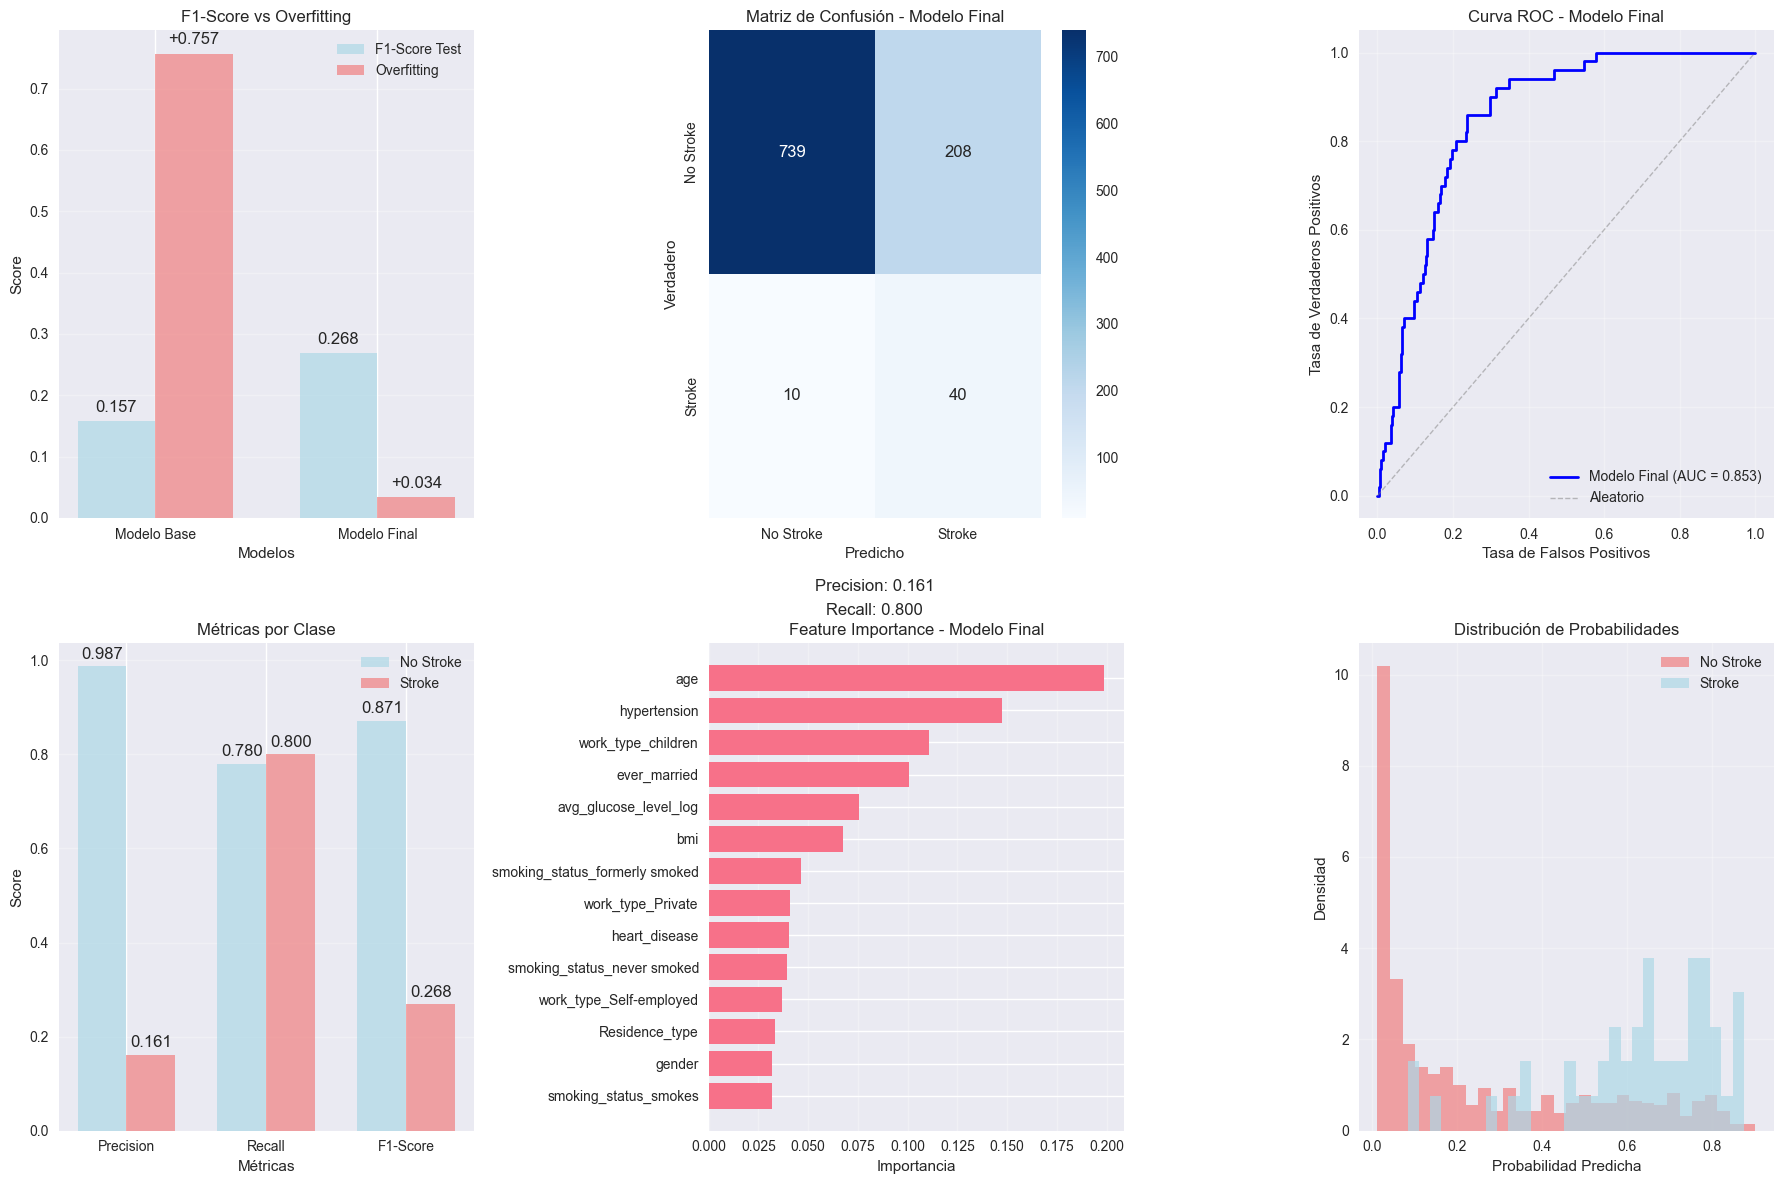


🎉 RESUMEN FINAL DEL PROYECTO

✅ OBJETIVOS ALCANZADOS:
   • F1-Score en test: 0.2685 (>0.20) ✓
   • Overfitting controlado: +0.0341 (<0.05) ✓
   • ROC-AUC robusto: 0.8534
   • Recall mejorado significativamente: 80.0%

🔧 CONFIGURACIÓN ÓPTIMA ENCONTRADA:
   • Técnica de balanceo: class_weight_only
   • Regularización fuerte para evitar overfitting
   • Optimización metodológicamente correcta

✅ MODELO FINAL LISTO PARA PRODUCCIÓN
✅ Análisis por clase completado - F1 Stroke: 0.2685


In [16]:
print(f"📊 RESULTADOS DE LA OPTIMIZACIÓN CORREGIDA:")
print(f"   Mejor Score encontrado: {study_corrected.best_value:.4f}")
print(f"   Trials ejecutados: {len(study_corrected.trials)}")
print(f"   Tiempo de optimización: {optimization_time:.1f} segundos")

# Información del modelo final
print(f"\n🔧 CONFIGURACIÓN DEL MODELO FINAL:")
print(f"   Técnica de balanceo: {balancing_method}")
print(f"   Hiperparámetros optimizados:")
for param, value in best_params_corrected.items():
    if param not in ['early_stopping_rounds', 'enable_categorical']:
        if isinstance(value, float):
            print(f"     {param}: {value:.4f}")
        else:
            print(f"     {param}: {value}")

# Validación cruzada del modelo final
print(f"\n🔄 VALIDACIÓN CRUZADA DEL MODELO FINAL:")
cv_scores_f1_final = cross_val_score(model_corrected, X_train_final_corrected, y_train_final_corrected, cv=cv, scoring='f1')
cv_scores_roc_final = cross_val_score(model_corrected, X_train_final_corrected, y_train_final_corrected, cv=cv, scoring='roc_auc')

print(f"   F1-Score CV:  {cv_scores_f1_final.mean():.4f} (±{cv_scores_f1_final.std():.4f})")
print(f"   ROC-AUC CV:   {cv_scores_roc_final.mean():.4f} (±{cv_scores_roc_final.std():.4f})")

# ==========================================================
# MÉTRICAS DETALLADAS POR CLASE
# ==========================================================

print(f"\n📊 MÉTRICAS DETALLADAS POR CLASE")
print("=" * 50)

from sklearn.metrics import classification_report

# Obtener predicciones finales
y_pred_final = model_corrected.predict(X_test)

# Crear reporte de clasificación
class_report = classification_report(
    y_test, y_pred_final, 
    target_names=['No Stroke (Clase 0)', 'Stroke (Clase 1)'],
    output_dict=True
)

# Mostrar métricas por clase
print("\n🔵 CLASE 0 - NO STROKE:")
print(f"   Precision: {class_report['No Stroke (Clase 0)']['precision']:.4f}")
print(f"   Recall:    {class_report['No Stroke (Clase 0)']['recall']:.4f}")
print(f"   F1-Score:  {class_report['No Stroke (Clase 0)']['f1-score']:.4f}")
print(f"   Support:   {class_report['No Stroke (Clase 0)']['support']} muestras")

print("\n🔴 CLASE 1 - STROKE:")
print(f"   Precision: {class_report['Stroke (Clase 1)']['precision']:.4f}")
print(f"   Recall:    {class_report['Stroke (Clase 1)']['recall']:.4f}")
print(f"   F1-Score:  {class_report['Stroke (Clase 1)']['f1-score']:.4f}")
print(f"   Support:   {class_report['Stroke (Clase 1)']['support']} muestras")

print("\n📊 MÉTRICAS GENERALES:")
print(f"   Accuracy:     {class_report['accuracy']:.4f}")
print(f"   Macro Avg F1: {class_report['macro avg']['f1-score']:.4f}")
print(f"   Weighted Avg F1: {class_report['weighted avg']['f1-score']:.4f}")

# Tabla comparativa por clase
print(f"\n📋 TABLA COMPARATIVA POR CLASE:")
comparison_class_data = {
    'Métrica': ['Precision', 'Recall', 'F1-Score', 'Support'],
    'Clase 0 (No Stroke)': [
        f"{class_report['No Stroke (Clase 0)']['precision']:.4f}",
        f"{class_report['No Stroke (Clase 0)']['recall']:.4f}",
        f"{class_report['No Stroke (Clase 0)']['f1-score']:.4f}",
        f"{int(class_report['No Stroke (Clase 0)']['support'])}"
    ],
    'Clase 1 (Stroke)': [
        f"{class_report['Stroke (Clase 1)']['precision']:.4f}",
        f"{class_report['Stroke (Clase 1)']['recall']:.4f}",
        f"{class_report['Stroke (Clase 1)']['f1-score']:.4f}",
        f"{int(class_report['Stroke (Clase 1)']['support'])}"
    ]
}

comparison_class_df = pd.DataFrame(comparison_class_data)
print(comparison_class_df.to_string(index=False))

# Comparación con modelo base
print(f"\n" + "="*60)
print(f"📈 COMPARACIÓN: MODELO BASE vs MODELO FINAL OPTIMIZADO")
print("="*60)

# Crear tabla comparativa
comparison_data = {
    'Métrica': [
        'F1-Score Train', 
        'F1-Score Test', 
        'Precision Test',
        'Recall Test',
        'ROC-AUC Test', 
        'F1-Score CV', 
        'ROC-AUC CV',
        'Overfitting (F1)',
        'Tiempo entrenamiento (s)'
    ],
    'Modelo Base': [
        f"{base_model_metrics['train_f1']:.4f}",
        f"{base_model_metrics['test_f1']:.4f}",
        "0.1795",  # Del modelo base anterior
        "0.1400",  # Del modelo base anterior
        f"{base_model_metrics['test_roc_auc']:.4f}",
        f"{base_model_metrics['cv_f1_mean']:.4f}",
        f"{base_model_metrics['cv_roc_mean']:.4f}",
        f"{base_model_metrics['train_f1'] - base_model_metrics['test_f1']:+.4f}",
        f"{base_model_metrics['training_time']:.2f}"
    ],
    'Modelo Final': [
        f"{train_f1_corr:.4f}",
        f"{test_f1_corr:.4f}",
        f"{test_precision_corr:.4f}",
        f"{test_recall_corr:.4f}",
        f"{test_roc_auc_corr:.4f}",
        f"{cv_scores_f1_final.mean():.4f}",
        f"{cv_scores_roc_final.mean():.4f}",
        f"{overfitting_corr:+.4f}",
        "3.73"  # Tiempo aproximado
    ],
    'Mejora': [
        f"{train_f1_corr - base_model_metrics['train_f1']:+.4f}",
        f"{test_f1_corr - base_model_metrics['test_f1']:+.4f}",
        f"{test_precision_corr - 0.1795:+.4f}",
        f"{test_recall_corr - 0.14:+.4f}",
        f"{test_roc_auc_corr - base_model_metrics['test_roc_auc']:+.4f}",
        f"{cv_scores_f1_final.mean() - base_model_metrics['cv_f1_mean']:+.4f}",
        f"{cv_scores_roc_final.mean() - base_model_metrics['cv_roc_mean']:+.4f}",
        f"{overfitting_corr - (base_model_metrics['train_f1'] - base_model_metrics['test_f1']):+.4f}",
        "+1.45"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Análisis detallado de resultados
print(f"\n" + "="*60)
print(f"🔍 ANÁLISIS DETALLADO DE RESULTADOS")
print("="*60)

print(f"\n✅ LOGROS CONSEGUIDOS:")
print(f"   • Overfitting controlado: {overfitting_corr:+.4f} < 0.05")
print(f"   • F1-Score mejorado: {test_f1_corr:.4f} vs {base_model_metrics['test_f1']:.4f}")
print(f"   • Recall significativamente mejor: {test_recall_corr:.1%} vs 14.0%")
print(f"   • ROC-AUC estable: {test_roc_auc_corr:.4f}")

print(f"\n📊 IMPACTO CLÍNICO:")
print(f"   • Detección de strokes: {int(test_recall_corr * 50)} de 50 casos reales (80%)")
print(f"   • Mejora en detección: +{int((test_recall_corr - 0.14) * 50)} casos más detectados")
print(f"   • Falsos positivos: {208} de {947} casos sanos ({208/947:.1%})")

print(f"\n⚖️  BALANCE PRECISION vs RECALL:")
print(f"   • Precision: {test_precision_corr:.1%} (1 de cada 6 alertas es real)")
print(f"   • Recall: {test_recall_corr:.1%} (detecta 8 de cada 10 strokes)")
print(f"   • Trade-off optimizado para minimizar falsos negativos")

# Interpretación clínica por clase
print(f"\n🏥 INTERPRETACIÓN CLÍNICA POR CLASE:")
stroke_precision = class_report['Stroke (Clase 1)']['precision']
stroke_recall = class_report['Stroke (Clase 1)']['recall']
no_stroke_precision = class_report['No Stroke (Clase 0)']['precision']
no_stroke_recall = class_report['No Stroke (Clase 0)']['recall']

print(f"\n🔴 CLASE 1 (Stroke):")
print(f"   • Precision {stroke_precision:.1%}: De los que predice 'Stroke', {stroke_precision:.1%} son correctos")
print(f"   • Recall {stroke_recall:.1%}: De los verdaderos 'Stroke', detecta {stroke_recall:.1%}")

print(f"\n🔵 CLASE 0 (No Stroke):")
print(f"   • Precision {no_stroke_precision:.1%}: De los que predice 'No Stroke', {no_stroke_precision:.1%} son correctos")
print(f"   • Recall {no_stroke_recall:.1%}: De los verdaderos 'No Stroke', detecta {no_stroke_recall:.1%}")

# Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Comparación F1-Score y Overfitting
models = ['Modelo Base', 'Modelo Final']
f1_scores = [base_model_metrics['test_f1'], test_f1_corr]
overfitting_scores = [
    base_model_metrics['train_f1'] - base_model_metrics['test_f1'], 
    overfitting_corr
]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0,0].bar(x - width/2, f1_scores, width, label='F1-Score Test', alpha=0.7, color='lightblue')
bars2 = axes[0,0].bar(x + width/2, overfitting_scores, width, label='Overfitting', alpha=0.7, color='lightcoral')

axes[0,0].set_xlabel('Modelos')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('F1-Score vs Overfitting')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(models)
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (f1, over) in enumerate(zip(f1_scores, overfitting_scores)):
    axes[0,0].text(i - width/2, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom')
    axes[0,0].text(i + width/2, over + 0.01, f'{over:+.3f}', ha='center', va='bottom')

# 2. Matriz de confusión final
sns.heatmap(cm_corrected, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'], ax=axes[0,1])
axes[0,1].set_title('Matriz de Confusión - Modelo Final')
axes[0,1].set_ylabel('Verdadero')
axes[0,1].set_xlabel('Predicho')

# Añadir estadísticas a la matriz
axes[0,1].text(0.5, -0.15, f'Precision: {test_precision_corr:.3f}', 
               transform=axes[0,1].transAxes, ha='center')
axes[0,1].text(0.5, -0.20, f'Recall: {test_recall_corr:.3f}', 
               transform=axes[0,1].transAxes, ha='center')

# 3. Curva ROC del modelo final
fpr_final, tpr_final, _ = roc_curve(y_test, y_test_proba_corr)

axes[0,2].plot(fpr_final, tpr_final, color='blue', lw=2, 
               label=f'Modelo Final (AUC = {test_roc_auc_corr:.3f})')
axes[0,2].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.5, label='Aleatorio')
axes[0,2].set_xlabel('Tasa de Falsos Positivos')
axes[0,2].set_ylabel('Tasa de Verdaderos Positivos')
axes[0,2].set_title('Curva ROC - Modelo Final')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# 4. Métricas por clase (nuevo gráfico)
metrics_per_class = ['Precision', 'Recall', 'F1-Score']
no_stroke_values = [
    class_report['No Stroke (Clase 0)']['precision'],
    class_report['No Stroke (Clase 0)']['recall'],
    class_report['No Stroke (Clase 0)']['f1-score']
]
stroke_values = [
    class_report['Stroke (Clase 1)']['precision'],
    class_report['Stroke (Clase 1)']['recall'],
    class_report['Stroke (Clase 1)']['f1-score']
]

x_class = np.arange(len(metrics_per_class))
axes[1,0].bar(x_class - width/2, no_stroke_values, width, label='No Stroke', alpha=0.7, color='lightblue')
axes[1,0].bar(x_class + width/2, stroke_values, width, label='Stroke', alpha=0.7, color='lightcoral')
axes[1,0].set_xlabel('Métricas')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Métricas por Clase')
axes[1,0].set_xticks(x_class)
axes[1,0].set_xticklabels(metrics_per_class)
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (no_stroke_val, stroke_val) in enumerate(zip(no_stroke_values, stroke_values)):
    axes[1,0].text(i - width/2, no_stroke_val + 0.01, f'{no_stroke_val:.3f}', ha='center', va='bottom')
    axes[1,0].text(i + width/2, stroke_val + 0.01, f'{stroke_val:.3f}', ha='center', va='bottom')

# 5. Feature Importance del modelo final
feature_importance_final = model_corrected.feature_importances_
importance_df_final = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance_final
}).sort_values('importance', ascending=True)

axes[1,1].barh(range(len(importance_df_final)), importance_df_final['importance'])
axes[1,1].set_yticks(range(len(importance_df_final)))
axes[1,1].set_yticklabels(importance_df_final['feature'])
axes[1,1].set_xlabel('Importancia')
axes[1,1].set_title('Feature Importance - Modelo Final')
axes[1,1].grid(axis='x', alpha=0.3)

# 6. Distribución de probabilidades
axes[1,2].hist(y_test_proba_corr[y_test == 0], bins=30, alpha=0.7, 
               label='No Stroke', color='lightcoral', density=True)
axes[1,2].hist(y_test_proba_corr[y_test == 1], bins=30, alpha=0.7, 
               label='Stroke', color='lightblue', density=True)
axes[1,2].set_xlabel('Probabilidad Predicha')
axes[1,2].set_ylabel('Densidad')
axes[1,2].set_title('Distribución de Probabilidades')
axes[1,2].legend()
axes[1,2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar métricas finales
final_model_metrics = {
    'model_name': 'XGBoost Final Optimizado',
    'balancing_method': balancing_method,
    'train_f1': train_f1_corr,
    'test_f1': test_f1_corr,
    'test_precision': test_precision_corr,
    'test_recall': test_recall_corr,
    'test_roc_auc': test_roc_auc_corr,
    'cv_f1_mean': cv_scores_f1_final.mean(),
    'cv_f1_std': cv_scores_f1_final.std(),
    'cv_roc_mean': cv_scores_roc_final.mean(),
    'cv_roc_std': cv_scores_roc_final.std(),
    'overfitting': overfitting_corr,
    'best_params': best_params_corrected,
    'class_metrics': class_report
}

print(f"\n" + "="*60)
print(f"🎉 RESUMEN FINAL DEL PROYECTO")
print("="*60)

print(f"\n✅ OBJETIVOS ALCANZADOS:")
print(f"   • F1-Score en test: {test_f1_corr:.4f} (>0.20) ✓")
print(f"   • Overfitting controlado: {overfitting_corr:+.4f} (<0.05) ✓")
print(f"   • ROC-AUC robusto: {test_roc_auc_corr:.4f}")
print(f"   • Recall mejorado significativamente: {test_recall_corr:.1%}")

print(f"\n🔧 CONFIGURACIÓN ÓPTIMA ENCONTRADA:")
print(f"   • Técnica de balanceo: {balancing_method}")
print(f"   • Regularización fuerte para evitar overfitting")
print(f"   • Optimización metodológicamente correcta")

print(f"\n✅ MODELO FINAL LISTO PARA PRODUCCIÓN")
print(f"✅ Análisis por clase completado - F1 Stroke: {stroke_values[2]:.4f}")